In [1]:
import pandas as pd
import psycopg2
import dotenv
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings
from mpl_toolkits.mplot3d import Axes3D
from lifetimes import BetaGeoFitter
from datetime import datetime

#### CARREGANDO BASE DE DADOS

In [2]:
# Nome do arquivo com timestamp para evitar sobrescrever arquivos anteriores
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

try:
    # Conectar ao PostgreSQL
    print("Conectando ao banco de dados PostgreSQL...")
    conn = psycopg2.connect(
        host= os.getenv("hostAWS"),
        database="add",
        user= os.getenv("userADD"),
        password= os.getenv("addPass")
    )
    
    print("Conexão estabelecida com sucesso!")
    
    ########################################################
    # consulta da tabela vendas
    ########################################################
    
    print("Consultando a tabela vendas...")
    query = "SELECT * FROM vendas"
    
    # Carregar os dados diretamente em um DataFrame do pandas
    df_vendas = pd.read_sql_query(query, conn)
    
    # Informações sobre os dados
    num_registros = len(df_vendas)
    num_colunas = len(df_vendas.columns)
    
    print(f"Dados obtidos com sucesso! {num_registros} registros e {num_colunas} colunas.")
    print(f"Colunas disponíveis: {', '.join(df_vendas.columns)}")
    
    # Exibir uma amostra dos dados
    print("\nPrimeiros 5 registros para verificação:")
    print(df_vendas.head())
    
    # Exportar para Excel
    #df_vendas.to_excel("df_vendas.xlsx", index=False)

    ########################################################
    # consulta da tabela clientes
    ########################################################
    
    # Consultar a tabela clientes
    print("Consultando a tabela clientes...")
    query = "SELECT * FROM clientes"
    
    # Carregar os dados diretamente em um DataFrame do pandas
    df_clientes = pd.read_sql_query(query, conn)
    
    # Informações sobre os dados
    num_registros = len(df_clientes)
    num_colunas = len(df_clientes.columns)
    
    print(f"Dados obtidos com sucesso! {num_registros} registros e {num_colunas} colunas.")
    print(f"Colunas disponíveis: {', '.join(df_clientes.columns)}")
    
    # Exibir uma amostra dos dados
    print("\nPrimeiros 5 registros para verificação:")
    print(df_clientes.head())
    
    # Exportar para Excel
    #df_clientes.to_excel("df_clientes.xlsx", index=False)

    # Fechar conexão
    conn.close()
    print("\nConexão com o banco de dados fechada.")

except Exception as e:
    print(f"Erro: {e}")
    print("\nVerifique se:")
    print("1. O PostgreSQL está rodando")
    print("2. O banco de dados 'add' existe")
    print("3. As credenciais de conexão estão corretas")

Conectando ao banco de dados PostgreSQL...
Conexão estabelecida com sucesso!
Consultando a tabela vendas...
Dados obtidos com sucesso! 21143 registros e 8 colunas.
Colunas disponíveis: id_venda, id_cliente, data_emissao, data_faturamento, total_venda, vendedor, status, tipo_pagamento

Primeiros 5 registros para verificação:
  id_venda  id_cliente data_emissao data_faturamento  total_venda  \
0   501883         650   2021-12-30       2022-01-04      1194.64   
1   501884         650   2021-12-30       2022-01-04      2025.68   
2   501885         650   2021-12-30       2022-01-04       205.54   
3   501965        1085   2021-12-30       2022-01-03      1185.00   
4   501966        1085   2021-12-30       2022-01-03       894.10   

        vendedor       status tipo_pagamento  
0  MARIA EDUARDA  Pedido/Pago         Boleto  
1  MARIA EDUARDA  Pedido/Pago         Boleto  
2  MARIA EDUARDA  Pedido/Pago         Boleto  
3  MARIA EDUARDA  Pedido/Pago         Boleto  
4  MARIA EDUARDA  Pedido

/var/folders/8y/5ndc5qwd1b38zpft_5ptb5280000gq/T/ipykernel_89806/3599602217.py:24: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_vendas = pd.read_sql_query(query, conn)
/var/folders/8y/5ndc5qwd1b38zpft_5ptb5280000gq/T/ipykernel_89806/3599602217.py:49: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_clientes = pd.read_sql_query(query, conn)


#### ANÁLISE EXPLORATÓRIA VENDAS E CLIENTES

In [3]:
# 1. Quantos id_cliente únicos?
unique_clientes = df_vendas['id_cliente'].nunique()
print(f"Quantidade de id_cliente únicos: {unique_clientes}")
unique_status = df_vendas['status'].nunique()
print(f"Quantidade de status únicos: {unique_status}")

# 2. Análise exploratória sobre a receita utilizando total_venda
print("\nAnálise exploratória da receita (total_venda):")
print(df_vendas['total_venda'].describe())

Quantidade de id_cliente únicos: 1332
Quantidade de status únicos: 14

Análise exploratória da receita (total_venda):
count    2.114300e+04
mean     1.890746e+03
std      1.950305e+04
min      0.000000e+00
25%      2.265500e+02
50%      5.184600e+02
75%      1.220625e+03
max      1.417889e+06
Name: total_venda, dtype: float64


In [4]:
df_vendas['data_emissao'] = pd.to_datetime(df_vendas['data_emissao'])
# Filtrando todos os status que começam com "Pedido"
df_vendas = df_vendas[df_vendas['status'].str.startswith('Pedido')]
pedido_status = df_vendas[df_vendas['status'].str.startswith('Pedido')]['status'].unique()
print(pedido_status)

['Pedido/Pago' 'Pedido/Concluído' 'Pedido' 'Pedido/Pendente'
 'Pedido/Entregue' 'Pedido/Faturado']


#### ANÁLISE DE RETENÇÃO POR SAFRAS DE CLIENTES

In [10]:
# Recency: Número de dias desde a última compra
data_referencia = df_vendas['data_emissao'].max()
recency = df_vendas.groupby('id_cliente')['data_emissao'].max().apply(lambda x: (data_referencia - x).days)

# Frequency: Número de pedidos únicos por cliente
frequency = df_vendas.groupby('id_cliente')['id_venda'].nunique()

# Monetary: Valor total gasto
monetary = df_vendas.groupby('id_cliente')['total_venda'].sum()

# Age (Antiguidade): Dias desde a primeira compra
age = df_vendas.groupby('id_cliente')['data_emissao'].min().apply(lambda x: (data_referencia - x).days)

# Combinar métricas em um único DataFrame
rfma = pd.DataFrame({
    'Recency': recency,
    'Frequency': frequency,
    'Monetary': monetary,
    'Age': age
})

# Resetar o índice para ter id_cliente como coluna
rfma = rfma.reset_index()

# Adicionar algumas verificações
print("\nEstatísticas das métricas RFMA:")
print("\nRecency (dias):")
print(rfma['Recency'].describe())
print("\nFrequency (número de pedidos):")
print(rfma['Frequency'].describe())
print("\nMonetary (valor total):")
print(rfma['Monetary'].describe())
print("\nAge (dias desde primeira compra):")
print(rfma['Age'].describe())

#Salvar o resultado em um arquivo CSV
# rfma.to_csv('RFMA_por_cliente.csv', index=False)

# Exibir o DataFrame RFMA
print("\nPrimeiras linhas do RFMA:")
print(rfma.head())

# Verificações adicionais
print("\nContagens de controle:")
print(f"Número total de clientes: {len(rfma)}")

# Verificação adicional para Age
print("\nVerificação de coerência:")
print("Clientes com Age menor que Recency:", len(rfma[rfma['Age'] < rfma['Recency']]))


Estatísticas das métricas RFMA:

Recency (dias):
count    1021.000000
mean      656.026445
std       574.573464
min         0.000000
25%        37.000000
50%       564.000000
75%      1233.000000
max      1530.000000
Name: Recency, dtype: float64

Frequency (número de pedidos):
count    1021.000000
mean       13.640548
std        27.756170
min         1.000000
25%         1.000000
50%         3.000000
75%        14.000000
max       268.000000
Name: Frequency, dtype: float64

Monetary (valor total):
count      1021.000000
mean      10790.320431
std       29679.308848
min           5.000000
25%         112.490000
50%         914.520000
75%        7268.300000
max      384804.780000
Name: Monetary, dtype: float64

Age (dias desde primeira compra):
count    1021.000000
mean      977.961802
std       473.373458
min         4.000000
25%       540.000000
50%      1134.000000
75%      1388.000000
max      1530.000000
Name: Age, dtype: float64

Primeiras linhas do RFMA:
   id_cliente  Recency  

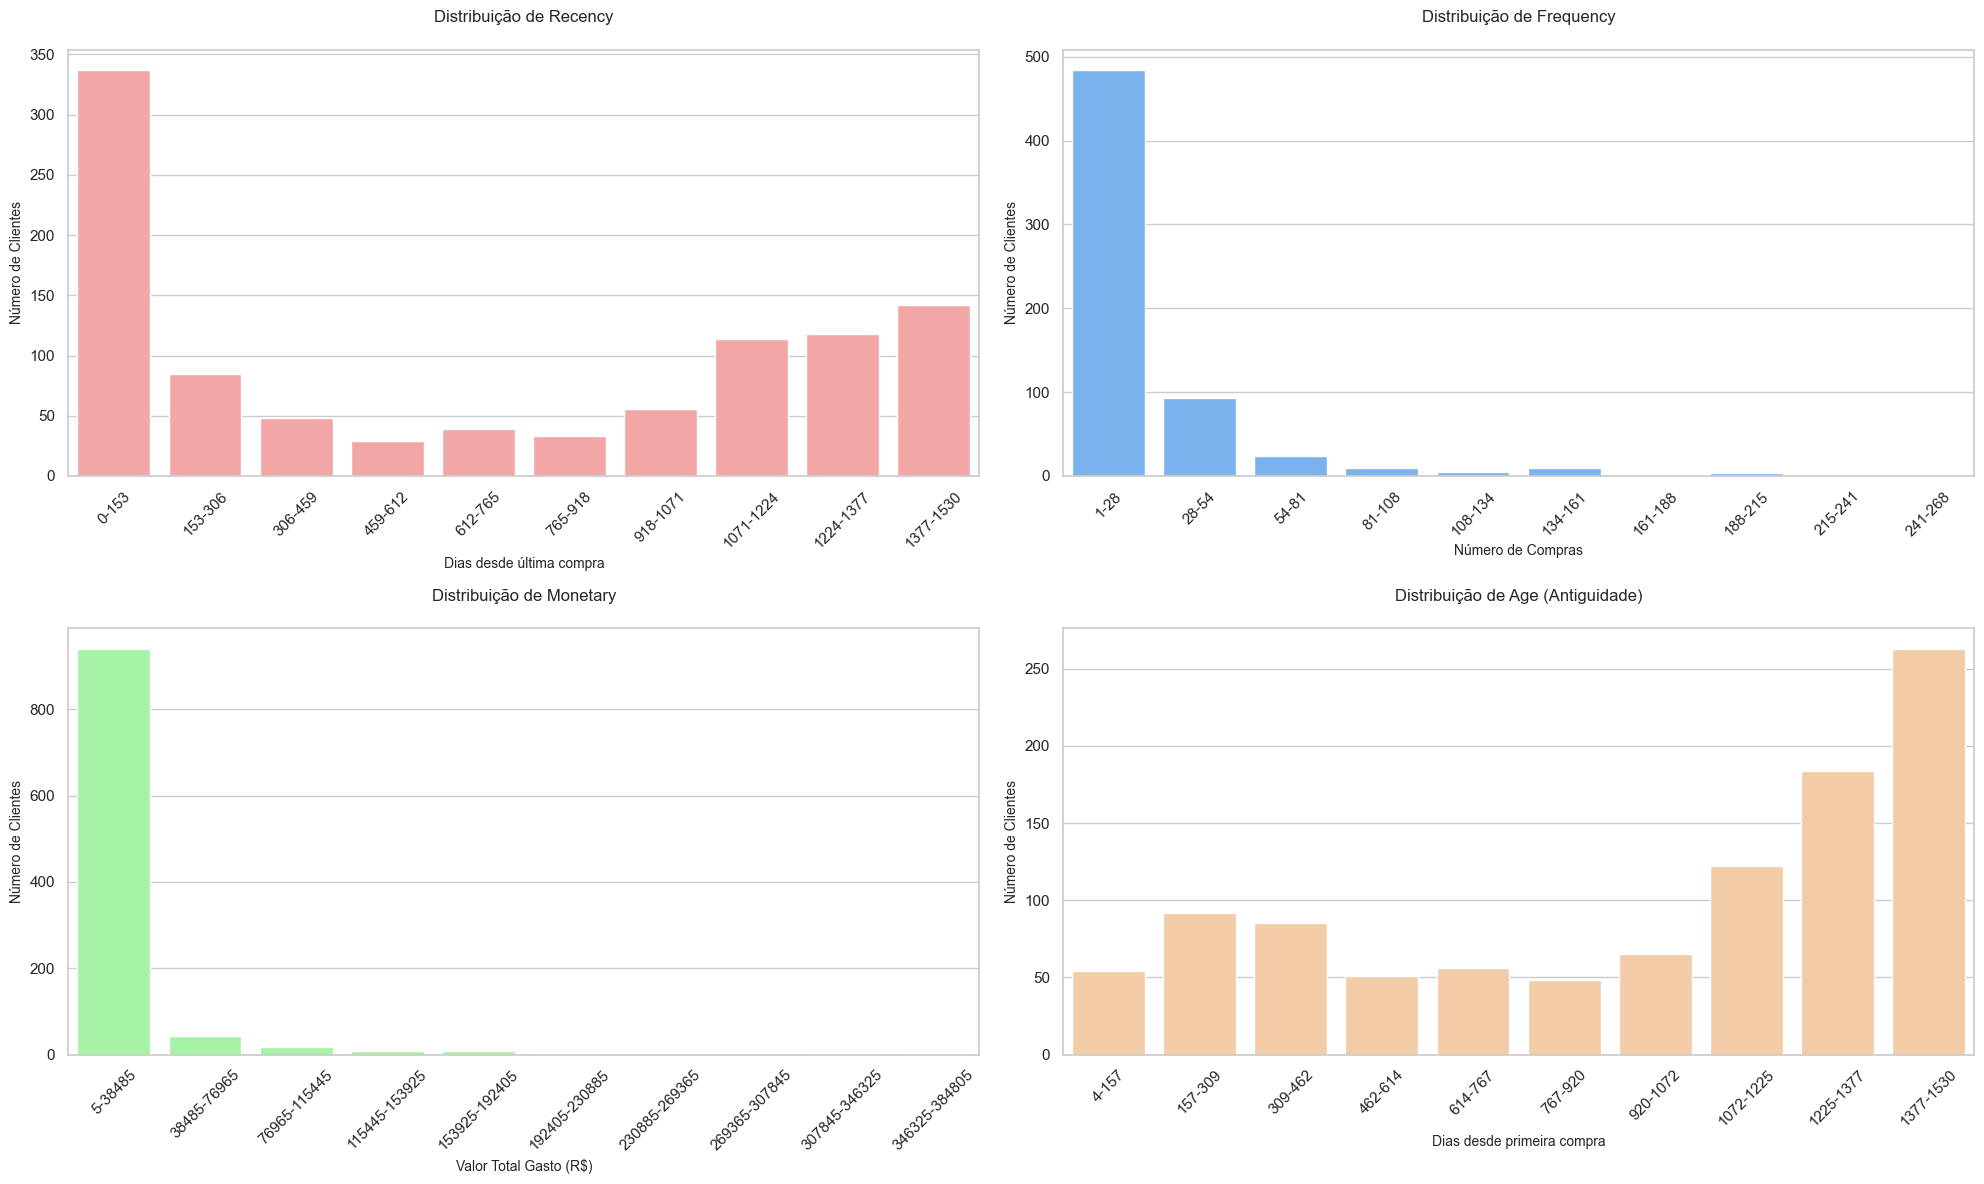


Distribuição de clientes por faixa:

Recency (dias):
R_range
0-153        337
153-306       85
306-459       48
459-612       29
612-765       39
765-918       33
918-1071      56
1071-1224    114
1224-1377    118
1377-1530    142
Name: count, dtype: int64

Frequency (compras):
F_range
1-28       484
28-54       93
54-81       24
81-108      10
108-134      5
134-161      9
161-188      1
188-215      4
215-241      1
241-268      1
Name: count, dtype: int64

Monetary (R$):
M_range
5-38485          941
38485-76965       44
76965-115445      17
115445-153925      7
153925-192405      8
192405-230885      1
230885-269365      0
269365-307845      0
307845-346325      1
346325-384805      1
Name: count, dtype: int64

Age (dias desde primeira compra):
A_range
4-157         54
157-309       92
309-462       85
462-614       51
614-767       56
767-920       48
920-1072      65
1072-1225    122
1225-1377    184
1377-1530    263
Name: count, dtype: int64


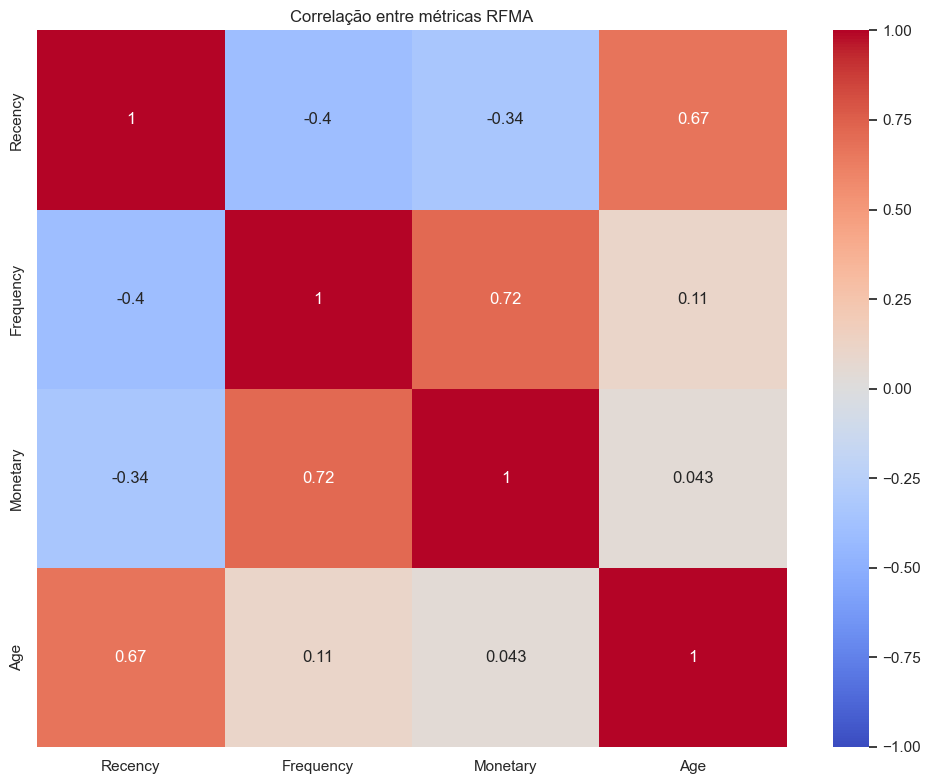

In [11]:
# Configuração básica do seaborn
sns.set(style="whitegrid")

# Criar bins e labels para cada métrica
def create_range_labels(data, bins):
    labels = []
    for i in range(len(bins)-1):
        labels.append(f'{bins[i]:.0f}-{bins[i+1]:.0f}')
    return labels

# Definir uma paleta de cores atraente
colors = ['#FF9999', '#66B2FF', '#99FF99', '#FFCC99']

# Recency
r_bins = np.linspace(rfma['Recency'].min(), rfma['Recency'].max(), 11)
r_labels = create_range_labels(rfma['Recency'], r_bins)
rfma['R_range'] = pd.cut(rfma['Recency'], bins=r_bins, labels=r_labels)

# Frequency
f_bins = np.linspace(rfma['Frequency'].min(), rfma['Frequency'].max(), 11)
f_labels = create_range_labels(rfma['Frequency'], f_bins)
rfma['F_range'] = pd.cut(rfma['Frequency'], bins=f_bins, labels=f_labels)

# Monetary
m_bins = np.linspace(rfma['Monetary'].min(), rfma['Monetary'].max(), 11)
m_labels = create_range_labels(rfma['Monetary'], m_bins)
rfma['M_range'] = pd.cut(rfma['Monetary'], bins=m_bins, labels=m_labels)

# Age (Antiguidade)
a_bins = np.linspace(rfma['Age'].min(), rfma['Age'].max(), 11)
a_labels = create_range_labels(rfma['Age'], a_bins)
rfma['A_range'] = pd.cut(rfma['Age'], bins=a_bins, labels=a_labels)

# Criar gráficos
fig, axes = plt.subplots(2, 2, figsize=(20, 12))

# Gráfico de Recency
r_counts = rfma['R_range'].value_counts().sort_index()
sns.barplot(x=r_counts.index, y=r_counts.values, ax=axes[0,0], color=colors[0])
axes[0,0].set_title('Distribuição de Recency', fontsize=12, pad=20)
axes[0,0].set_xlabel('Dias desde última compra', fontsize=10)
axes[0,0].set_ylabel('Número de Clientes', fontsize=10)
axes[0,0].tick_params(axis='x', rotation=45)

# Gráfico de Frequency
f_counts = rfma['F_range'].value_counts().sort_index()
sns.barplot(x=f_counts.index, y=f_counts.values, ax=axes[0,1], color=colors[1])
axes[0,1].set_title('Distribuição de Frequency', fontsize=12, pad=20)
axes[0,1].set_xlabel('Número de Compras', fontsize=10)
axes[0,1].set_ylabel('Número de Clientes', fontsize=10)
axes[0,1].tick_params(axis='x', rotation=45)

# Gráfico de Monetary
m_counts = rfma['M_range'].value_counts().sort_index()
sns.barplot(x=m_counts.index, y=m_counts.values, ax=axes[1,0], color=colors[2])
axes[1,0].set_title('Distribuição de Monetary', fontsize=12, pad=20)
axes[1,0].set_xlabel('Valor Total Gasto (R$)', fontsize=10)
axes[1,0].set_ylabel('Número de Clientes', fontsize=10)
axes[1,0].tick_params(axis='x', rotation=45)

# Gráfico de Age (Antiguidade)
a_counts = rfma['A_range'].value_counts().sort_index()
sns.barplot(x=a_counts.index, y=a_counts.values, ax=axes[1,1], color=colors[3])
axes[1,1].set_title('Distribuição de Age (Antiguidade)', fontsize=12, pad=20)
axes[1,1].set_xlabel('Dias desde primeira compra', fontsize=10)
axes[1,1].set_ylabel('Número de Clientes', fontsize=10)
axes[1,1].tick_params(axis='x', rotation=45)

# Ajustar o layout
plt.tight_layout()
plt.show()

# Imprimir distribuição
print("\nDistribuição de clientes por faixa:")
print("\nRecency (dias):")
print(r_counts)
print("\nFrequency (compras):")
print(f_counts)
print("\nMonetary (R$):")
print(m_counts)
print("\nAge (dias desde primeira compra):")
print(a_counts)

# Análises adicionais de correlação
correlation_matrix = rfma[['Recency', 'Frequency', 'Monetary', 'Age']].corr()

# Plotar mapa de calor das correlações
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlação entre métricas RFMA')
plt.tight_layout()
plt.show()

#### RFMA - ANÁLISE DE CLIENTES POR DECIS 

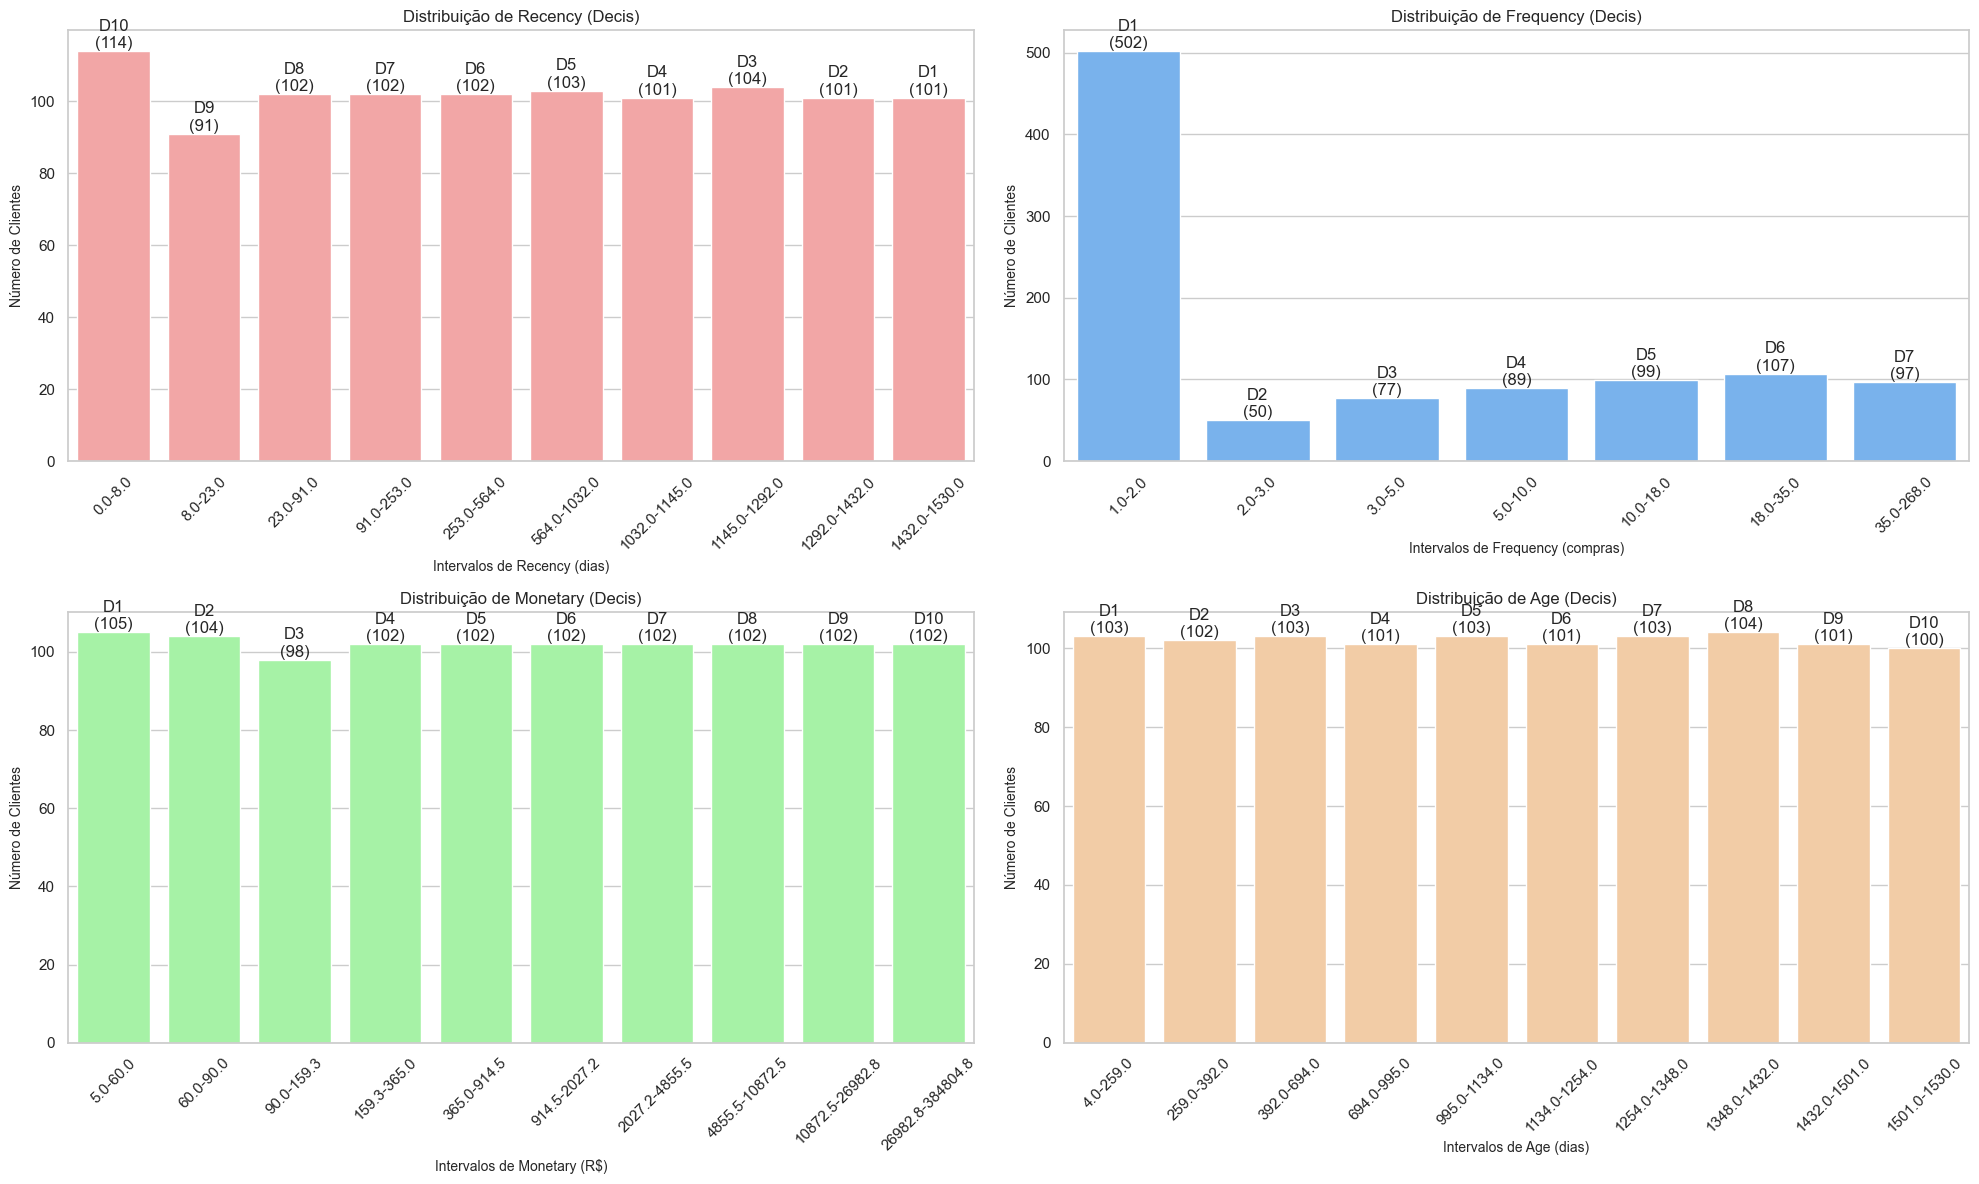


Exemplo dos primeiros registros com decis:
   Recency R_decil  Frequency F_decil  Monetary M_decil     Age A_decil
0   1129.0       4        2.0       1    108.09       3  1346.0       7
1     15.0       9      218.0       7  23324.14       9  1530.0      10
2   1319.0       2        1.0       1    100.00       3  1319.0       7
3   1269.0       3        3.0       2    197.98       4  1457.0       9
4   1299.0       2        1.0       1   1129.18       6  1299.0       7

Distribuição de clientes por faixa:

Recency (Ranges):
R_range
0.0-8.0          114
8.0-23.0          91
23.0-91.0        102
91.0-253.0       102
253.0-564.0      102
564.0-1032.0     103
1032.0-1145.0    101
1145.0-1292.0    104
1292.0-1432.0    101
1432.0-1530.0    101
Name: count, dtype: int64

Frequency (Ranges):
F_range
1.0-2.0       502
2.0-3.0        50
3.0-5.0        77
5.0-10.0       89
10.0-18.0      99
18.0-35.0     107
35.0-268.0     97
Name: count, dtype: int64

Monetary (Ranges):
M_range
5.0-60.0       

In [12]:
# Converter as colunas para float (caso estejam em decimal.Decimal)
for col in ['Recency', 'Frequency', 'Monetary', 'Age']:
    rfma[col] = rfma[col].astype(float)

# Criar decis para cada métrica RFMA
# Primeiro vamos obter os bins para cada métrica
_, r_bins = pd.qcut(rfma['Recency'], q=10, duplicates='drop', retbins=True)
_, f_bins = pd.qcut(rfma['Frequency'], q=10, duplicates='drop', retbins=True)
_, m_bins = pd.qcut(rfma['Monetary'], q=10, duplicates='drop', retbins=True)
_, a_bins = pd.qcut(rfma['Age'], q=10, duplicates='drop', retbins=True)

# Agora criar os labels com o número correto de categorias
r_labels = list(range(len(r_bins)-1, 0, -1))  # Ordem inversa para Recency
f_labels = list(range(1, len(f_bins)))  # Ordem normal para os demais
m_labels = list(range(1, len(m_bins)))
a_labels = list(range(1, len(a_bins)))

# Aplicar os decis
rfma['R_decil'] = pd.qcut(rfma['Recency'], q=10, labels=r_labels, duplicates='drop')
rfma['F_decil'] = pd.qcut(rfma['Frequency'], q=10, labels=f_labels, duplicates='drop')
rfma['M_decil'] = pd.qcut(rfma['Monetary'], q=10, labels=m_labels, duplicates='drop')
rfma['A_decil'] = pd.qcut(rfma['Age'], q=10, labels=a_labels, duplicates='drop')

# Criar ranges para visualização
r_bins = pd.qcut(rfma['Recency'], q=10, duplicates="drop", retbins=True)[1]
rfma['R_range'] = pd.cut(
    rfma['Recency'], 
    bins=r_bins, 
    labels=[f"{r_bins[i]:.1f}-{r_bins[i+1]:.1f}" for i in range(len(r_bins)-1)], 
    include_lowest=True
)

f_bins = pd.qcut(rfma['Frequency'], q=10, duplicates="drop", retbins=True)[1]
rfma['F_range'] = pd.cut(
    rfma['Frequency'], 
    bins=f_bins, 
    labels=[f"{f_bins[i]:.1f}-{f_bins[i+1]:.1f}" for i in range(len(f_bins)-1)], 
    include_lowest=True
)

m_bins = pd.qcut(rfma['Monetary'], q=10, duplicates="drop", retbins=True)[1]
rfma['M_range'] = pd.cut(
    rfma['Monetary'], 
    bins=m_bins, 
    labels=[f"{m_bins[i]:.1f}-{m_bins[i+1]:.1f}" for i in range(len(m_bins)-1)], 
    include_lowest=True
)

a_bins = pd.qcut(rfma['Age'], q=10, duplicates="drop", retbins=True)[1]
rfma['A_range'] = pd.cut(
    rfma['Age'], 
    bins=a_bins, 
    labels=[f"{a_bins[i]:.1f}-{a_bins[i+1]:.1f}" for i in range(len(a_bins)-1)], 
    include_lowest=True
)

# Configurar estilo do gráfico
sns.set(style="whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(20, 12))

# Gráfico de Recency
r_counts = rfma['R_range'].value_counts().sort_index()
sns.barplot(x=r_counts.index, y=r_counts.values, ax=axes[0,0], color='#FF9999')
axes[0,0].set_title('Distribuição de Recency (Decis)', fontsize=12)
axes[0,0].set_xlabel('Intervalos de Recency (dias)', fontsize=10)
axes[0,0].set_ylabel('Número de Clientes', fontsize=10)
axes[0,0].tick_params(axis='x', rotation=45)

# Adicionar valores e decis no topo das barras de Recency
for i, v in enumerate(r_counts):
    decil = 10 - i  # Decil invertido para Recency
    axes[0,0].text(i, v, f'D{decil}\n({int(v)})', ha='center', va='bottom')

# Gráfico de Frequency
f_counts = rfma['F_range'].value_counts().sort_index()
sns.barplot(x=f_counts.index, y=f_counts.values, ax=axes[0,1], color='#66B2FF')
axes[0,1].set_title('Distribuição de Frequency (Decis)', fontsize=12)
axes[0,1].set_xlabel('Intervalos de Frequency (compras)', fontsize=10)
axes[0,1].set_ylabel('Número de Clientes', fontsize=10)
axes[0,1].tick_params(axis='x', rotation=45)

# Adicionar valores e decis no topo das barras de Frequency
for i, v in enumerate(f_counts):
    decil = i + 1
    axes[0,1].text(i, v, f'D{decil}\n({int(v)})', ha='center', va='bottom')

# Gráfico de Monetary
m_counts = rfma['M_range'].value_counts().sort_index()
sns.barplot(x=m_counts.index, y=m_counts.values, ax=axes[1,0], color='#99FF99')
axes[1,0].set_title('Distribuição de Monetary (Decis)', fontsize=12)
axes[1,0].set_xlabel('Intervalos de Monetary (R$)', fontsize=10)
axes[1,0].set_ylabel('Número de Clientes', fontsize=10)
axes[1,0].tick_params(axis='x', rotation=45)

# Adicionar valores e decis no topo das barras de Monetary
for i, v in enumerate(m_counts):
    decil = i + 1
    axes[1,0].text(i, v, f'D{decil}\n({int(v)})', ha='center', va='bottom')

# Gráfico de Age (Antiguidade)
a_counts = rfma['A_range'].value_counts().sort_index()
sns.barplot(x=a_counts.index, y=a_counts.values, ax=axes[1,1], color='#FFCC99')
axes[1,1].set_title('Distribuição de Age (Decis)', fontsize=12)
axes[1,1].set_xlabel('Intervalos de Age (dias)', fontsize=10)
axes[1,1].set_ylabel('Número de Clientes', fontsize=10)
axes[1,1].tick_params(axis='x', rotation=45)

# Adicionar valores e decis no topo das barras de Age
for i, v in enumerate(a_counts):
    decil = i + 1
    axes[1,1].text(i, v, f'D{decil}\n({int(v)})', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Imprimir exemplo dos primeiros registros com os decis
print("\nExemplo dos primeiros registros com decis:")
print(rfma[['Recency', 'R_decil', 'Frequency', 'F_decil', 
            'Monetary', 'M_decil', 'Age', 'A_decil']].head())

# Imprimir distribuição
print("\nDistribuição de clientes por faixa:")
print("\nRecency (Ranges):")
print(r_counts)
print("\nFrequency (Ranges):")
print(f_counts)
print("\nMonetary (Ranges):")
print(m_counts)
print("\nAge (Ranges):")
print(a_counts)

#### RFMA - SEGMENTAÇÃO BASEADA EM REGRAS

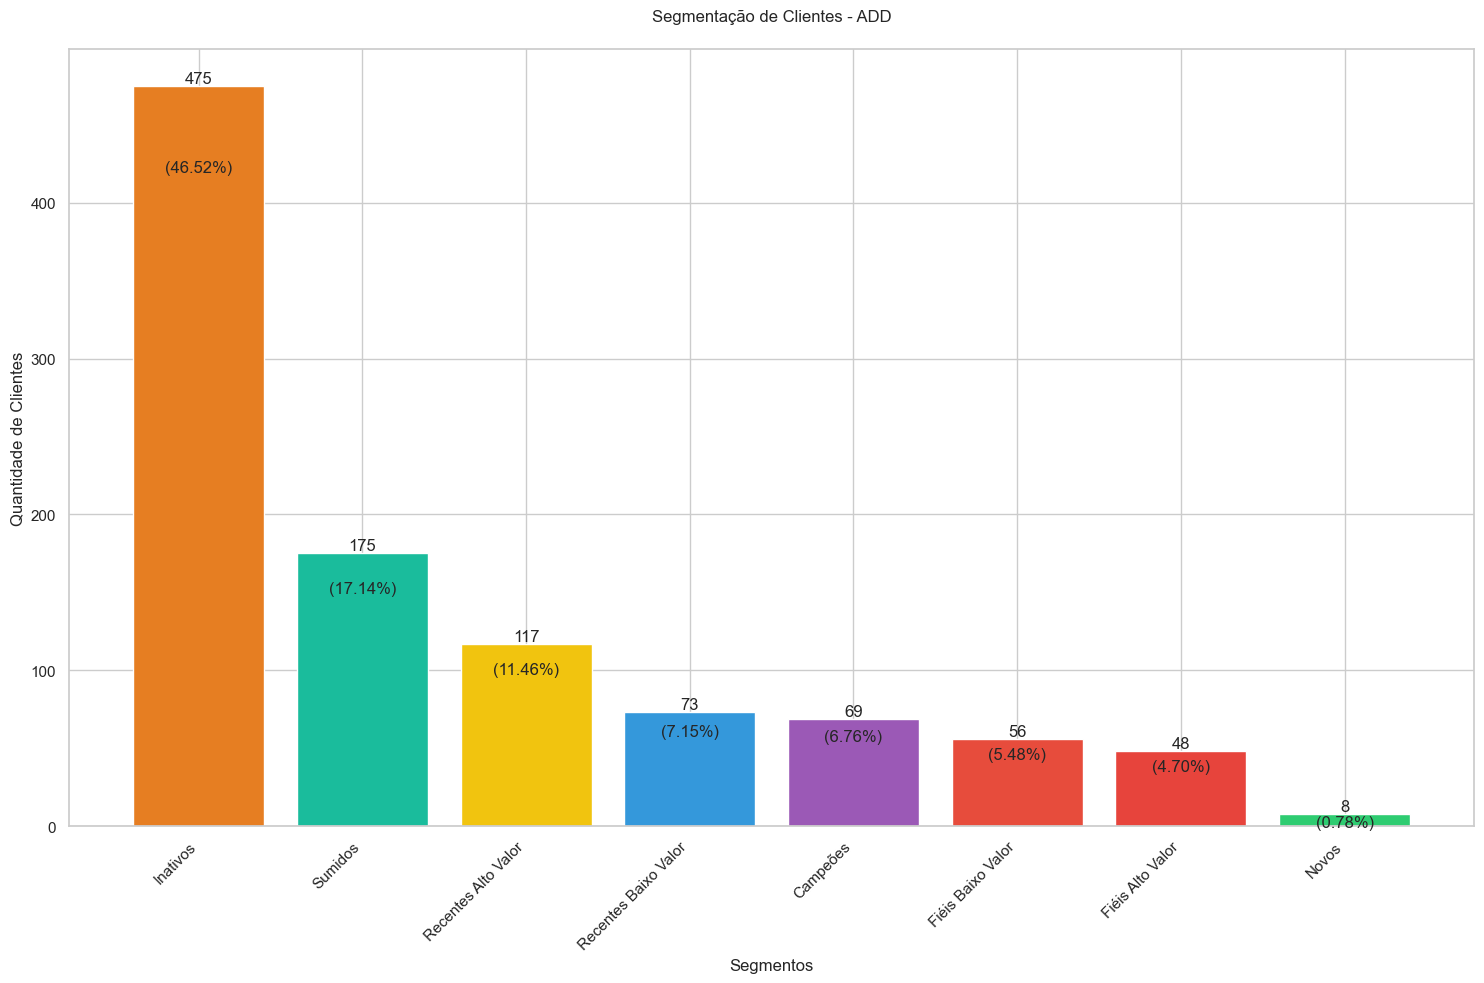


Análise Detalhada por Segmento:
                      Quantidade Clientes  Média Recency (dias)  \
Segmento                                                          
Inativos                              475               1233.89   
Sumidos                               175                393.99   
Recentes Alto Valor                   117                 35.96   
Recentes Baixo Valor                   73                 74.86   
Campeões                               69                 15.68   
Fiéis Baixo Valor                      56                 48.52   
Fiéis Alto Valor                       48                 24.73   
Novos                                   8                 12.25   

                      Média Frequency  Média Monetary (R$)  Média Age (dias)  
Segmento                                                                      
Inativos                         3.28              1266.40           1309.24  
Sumidos                         10.11              8271.01 

In [13]:
def segment_customers(df):
    """
    Segmenta clientes com base em regras atualizadas, de acordo com a análise da distribuição por faixa.
    
    Parâmetros:
    - Recency: dias desde a última compra
    - Age: dias desde a primeira compra (antiguidade)
    - Frequency: número de compras
    - Monetary: valor médio das compras
    """
    # Criar cópia do dataframe
    df_seg = df.copy()
    
    # Definir condições de forma mutuamente exclusiva

    cond_novos = (df_seg['Recency'] <= 30) & (df_seg['Age'] <= 30) # primeira compra no último mês

    cond_campeoes = (df_seg['Recency'] <= 180) & \
                    (df_seg['Frequency'] >= 34) & (df_seg['M_decil'] == 10) # clientes que compraram nos últimos 6 meses, possuem frequência de 37 ou mais e possuem valor monetário acima da média
                    
    cond_fieis_baixo_valor = (df_seg['Recency'] <= 180) & (df_seg['Age'] >= 730) & \
                 (df_seg['Frequency'] >= 4) & (df_seg['M_decil'] <= 8) # clientes há mais de 2 anos que compraram nos últimos 6 meses e possuem valor monetário menor ou igual a média
    
    cond_fieis_alto_valor = (df_seg['Recency'] <= 180) & (df_seg['Age'] >= 730) & \
                 (df_seg['Frequency'] >= 4) & (df_seg['M_decil'] > 8) # clientes há mais de 2 anos que compraram nos últimos 6 meses e possuem valor monetário acima da média
                 
    cond_recentes_alto = (df_seg['Recency'] <= 180) & \
                         (df_seg['Frequency'] >= 1) & (df_seg['M_decil'] > 6) # clientes que compraram nos últimos 6 meses e possui valor monetário acima da média
                         
    cond_recentes_baixo = (df_seg['Recency'] <= 180) & \
                          (df_seg['Frequency'] >= 1) & (df_seg['M_decil'] <= 6) # clientes que compraram nos últimos 6 meses e possui valor monetário abaixo da média
    
    # Clientes menos ativos
    cond_sumidos = (df_seg['Recency'] > 180) & (df_seg['Recency'] <= 730) # última compra entre 6 meses e 2 anos
    cond_inativos = (df_seg['Recency'] > 730) # sem comprar faz 2 anos
    
    # Lista de condições e respectivos rótulos
    conditions = [
        cond_novos,
        cond_campeoes,
        cond_fieis_baixo_valor,
        cond_fieis_alto_valor,
        cond_recentes_alto,
        cond_recentes_baixo,
        cond_sumidos,
        cond_inativos
    ]
    
    labels = [
        'Novos',
        'Campeões',
        'Fiéis Baixo Valor',
        'Fiéis Alto Valor',
        'Recentes Alto Valor',
        'Recentes Baixo Valor',
        'Sumidos',
        'Inativos'
    ]
    
    # Aplicar segmentação
    df_seg['Segmento'] = np.select(conditions, labels, default='Não Classificado')
    
    # Definir cores para cada segmento
    cores_segmento = {
        'Novos': '#2ecc71',               # Verde
        'Campeões': '#9b59b6',            # Roxo
        'Fiéis Baixo Valor': '#e74c3c',   # Vermelho
        'Fiéis Alto Valor' : '#e7443c',  
        'Recentes Alto Valor': '#f1c40f', # Amarelo
        'Recentes Baixo Valor': '#3498db',# Azul
        'Sumidos': '#1abc9c',             # Turquesa
        'Inativos': '#e67e22'             # Laranja
    }
    
    # Agregar dados para análise dos segmentos
    analise_segmentos = df_seg.groupby('Segmento').agg({
        'id_cliente': 'count',
        'Recency': 'mean',
        'Frequency': 'mean',
        'Monetary': 'mean',
        'Age': 'mean'
    }).round(2)
    
    analise_segmentos.columns = [
        'Quantidade Clientes',
        'Média Recency (dias)',
        'Média Frequency',
        'Média Monetary (R$)',
        'Média Age (dias)'
    ]
    
    # Ordenar por quantidade de clientes
    analise_segmentos = analise_segmentos.sort_values('Quantidade Clientes', ascending=False)
    
    # Visualização dos segmentos
    plt.figure(figsize=(15, 10))
    total_clientes = analise_segmentos['Quantidade Clientes'].sum()
    
    bars = plt.bar(
        analise_segmentos.index,
        analise_segmentos['Quantidade Clientes'],
        color=[cores_segmento.get(seg, '#95a5a6') for seg in analise_segmentos.index]
    )
    
    plt.title('Segmentação de Clientes - ADD', pad=20)
    plt.xlabel('Segmentos')
    plt.ylabel('Quantidade de Clientes')
    plt.xticks(rotation=45, ha='right')
    
    # Adicionar valores e porcentagens nas barras
    for bar in bars:
        height = bar.get_height()
        percentage = (height / total_clientes) * 100
        
        plt.text(
            bar.get_x() + bar.get_width()/2,
            height,
            f'{int(height):,}',
            ha='center',
            va='bottom'
        )
        
        plt.text(
            bar.get_x() + bar.get_width()/2,
            height * 0.9,
            f'({percentage:.2f}%)',
            ha='center',
            va='top'
        )
    
    plt.tight_layout()
    plt.show()
    
    return df_seg, analise_segmentos

# Usar a função
rfma_segmentado, analise = segment_customers(rfma)

# Salvar resultados
# rfma_segmentado.to_excel('rfma_segmentado_regras.xlsx', index=False)
# print("\nResultados salvos em 'rfma_segmentado_regras.xlsx'")

# Exibir análise
print("\nAnálise Detalhada por Segmento:")
print("=" * 120)
print(analise)

#### Preparando dados para o Dashboard da ADD

In [14]:
rfma_segmentado = rfma_segmentado.merge(df_clientes[['id_cliente', 'nome_cliente']], on='id_cliente', how='left')
rfma_segmentado = rfma_segmentado.rename(columns={'nome_cliente': 'nome'})
print(rfma_segmentado.columns)
#Arquivo usado para o dash de segmentação
rfma_segmentado.to_csv('analytics_cliente_ADD.csv', index=False)

print("Merge concluído. Arquivo salvo como 'analytics_cliente_ADD.csv'.")

Index(['id_cliente', 'Recency', 'Frequency', 'Monetary', 'Age', 'R_range',
       'F_range', 'M_range', 'A_range', 'R_decil', 'F_decil', 'M_decil',
       'A_decil', 'Segmento', 'nome'],
      dtype='object')
Merge concluído. Arquivo salvo como 'analytics_cliente_ADD.csv'.


#### PREDIÇÃO DE COMPRAS POR CLIENTE NOS PRÓXIMOS 30 DIAS

Optimization terminated successfully.
         Current function value: -90.807130
         Iterations: 18
         Function evaluations: 21
         Gradient evaluations: 21

Parâmetros do Modelo:
<lifetimes.BetaGeoFitter: fitted with 469 subjects, a: 0.15, alpha: 32.37, b: 1.98, r: 1.37>

Estatísticas das Previsões:
count    4.590000e+02
mean     7.405696e-01
std      9.124991e-01
min      3.221577e-16
25%      1.507897e-02
50%      4.603554e-01
75%      1.012390e+00
max      4.134497e+00
Name: predicted_purchases_30d, dtype: float64


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lifetimes/fitters/__init__.py:101: OptimizeWarning: Unknown solver options: iterative_fitting
  output = minimize(


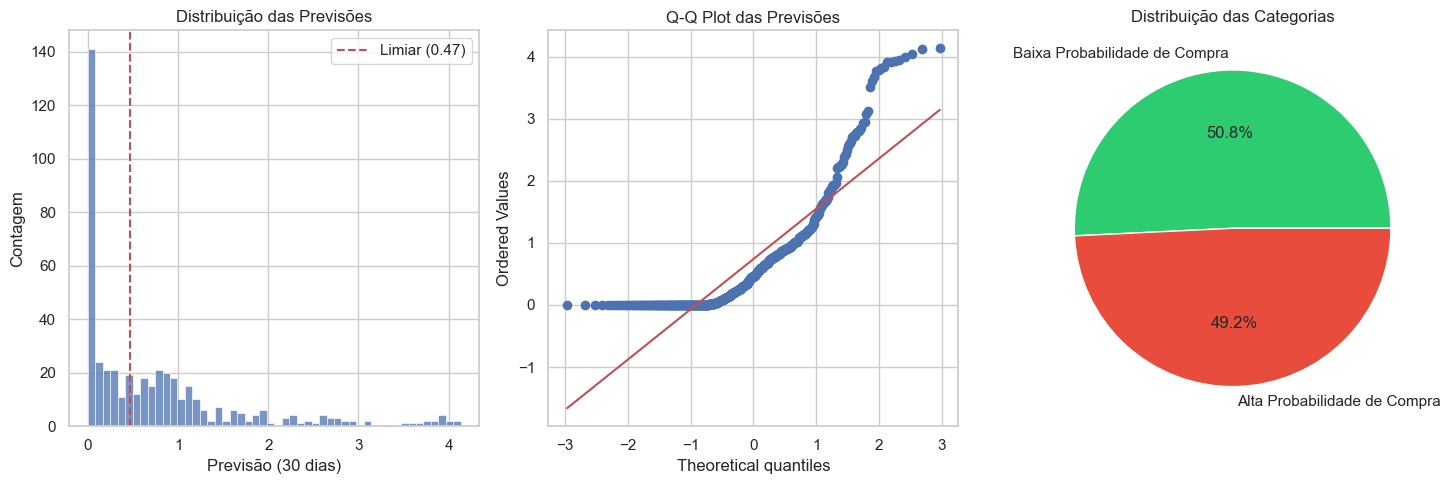


Análise por Categoria de Previsão:
                              Frequency              Recency         Monetary  \
                                   mean median count    mean median      mean   
categoria_previsao                                                              
Alta Probabilidade de Compra      39.22   27.5   226   18.51   15.0  33799.13   
Baixa Probabilidade de Compra     14.05    9.0   233  538.16  375.0  10672.40   

                                        predicted_purchases_30d               \
                                 median                    mean median   min   
categoria_previsao                                                             
Alta Probabilidade de Compra   14990.18                    1.39   1.02  0.47   
Baixa Probabilidade de Compra   3752.45                    0.11   0.02  0.00   

                                     
                                max  
categoria_previsao                   
Alta Probabilidade de Compra   4.13  
Baixa

In [15]:
# Pré-processamento para o modelo BG/NBD
rfma = rfma_segmentado.copy()

# Limpeza e tratamento dos dados
rfma = rfma[rfma['Frequency'] > 3]

# Ajustar os valores para evitar problemas numéricos
rfma['frequency_adjusted'] = rfma['Frequency'] - 1
rfma['recency_bg'] = (rfma['Age'] - rfma['Recency']).clip(lower=1)  # Garantir valores positivos
rfma['T'] = rfma['Age'].clip(lower=1)  # Garantir valores positivos

# Remover outliers extremos
for col in ['frequency_adjusted', 'recency_bg', 'T']:
    Q1 = rfma[col].quantile(0.01)
    Q3 = rfma[col].quantile(0.99)
    IQR = Q3 - Q1
    rfma = rfma[
        (rfma[col] >= Q1 - 1.5 * IQR) &
        (rfma[col] <= Q3 + 1.5 * IQR)
    ]

# Ajuste do Modelo BG/NBD com parâmetros para melhor convergência
bgf = BetaGeoFitter(penalizer_coef=0.01)  # Aumentar penalizador
bgf.fit(
    rfma['frequency_adjusted'],
    rfma['recency_bg'],
    rfma['T'],
    iterative_fitting=2,          # Reduzir número de iterações
    tol=1e-4,                     # Aumentar tolerância
    initial_params=None,          # Permitir estimativa automática
    verbose=True                  # Mostrar progresso
)

# Calcular previsões para 30 dias
rfma['predicted_purchases_30d'] = bgf.conditional_expected_number_of_purchases_up_to_time(
    30,
    rfma['frequency_adjusted'],
    rfma['recency_bg'],
    rfma['T']
)

# Remover previsões extremas ou inválidas
rfma = rfma[rfma['predicted_purchases_30d'].between(
    rfma['predicted_purchases_30d'].quantile(0.01),
    rfma['predicted_purchases_30d'].quantile(0.99)
)]

# Imprimir parâmetros do modelo
print("\nParâmetros do Modelo:")
print(bgf)
print("\nEstatísticas das Previsões:")
print(rfma['predicted_purchases_30d'].describe())

# Definir limiar usando método mais robusto
limiar = rfma['predicted_purchases_30d'].median() + \
         rfma['predicted_purchases_30d'].std() * 0.01

# Classificar clientes
rfma['categoria_previsao'] = np.where(
    rfma['predicted_purchases_30d'] >= limiar,
    'Alta Probabilidade de Compra',
    'Baixa Probabilidade de Compra'
)

# Visualizações
plt.figure(figsize=(15, 5))

# 1. Distribuição das Previsões
plt.subplot(1, 3, 1)
sns.histplot(data=rfma, x='predicted_purchases_30d', bins=50)
plt.axvline(x=limiar, color='r', linestyle='--', label=f'Limiar ({limiar:.2f})')
plt.title('Distribuição das Previsões')
plt.xlabel('Previsão (30 dias)')
plt.ylabel('Contagem')
plt.legend()

# 2. QQ-Plot para verificar normalidade
plt.subplot(1, 3, 2)
from scipy.stats import probplot
probplot(rfma['predicted_purchases_30d'], dist="norm", plot=plt)
plt.title('Q-Q Plot das Previsões')

# 3. Contagem por Categoria
plt.subplot(1, 3, 3)
contagem = rfma['categoria_previsao'].value_counts()
plt.pie(contagem, labels=contagem.index, autopct='%1.1f%%',
        colors=['#2ecc71', '#e74c3c'])
plt.title('Distribuição das Categorias')

plt.tight_layout()
plt.show()

# Análise por categoria
print("\nAnálise por Categoria de Previsão:")
analise_categoria = rfma.groupby('categoria_previsao').agg({
    'Frequency': ['mean', 'median', 'count'],
    'Recency': ['mean', 'median'],
    'Monetary': ['mean', 'median'],
    'predicted_purchases_30d': ['mean', 'median', 'min', 'max']
}).round(2)

print(analise_categoria)

# Validação das previsões
print("\nValidação do Modelo:")
print(f"Média de transações previstas: {rfma['predicted_purchases_30d'].mean():.2f}")
print(f"Mediana de transações previstas: {rfma['predicted_purchases_30d'].median():.2f}")
print(f"% de clientes com alta probabilidade: {(rfma['categoria_previsao'] == 'Alta Probabilidade de Compra').mean()*100:.1f}%")

# Salvar resultados
rfma.to_excel('rfma_previsoes_ajustado.xlsx', index=False)
print("\nResultados salvos em 'rfma_previsoes_ajustado.xlsx'")

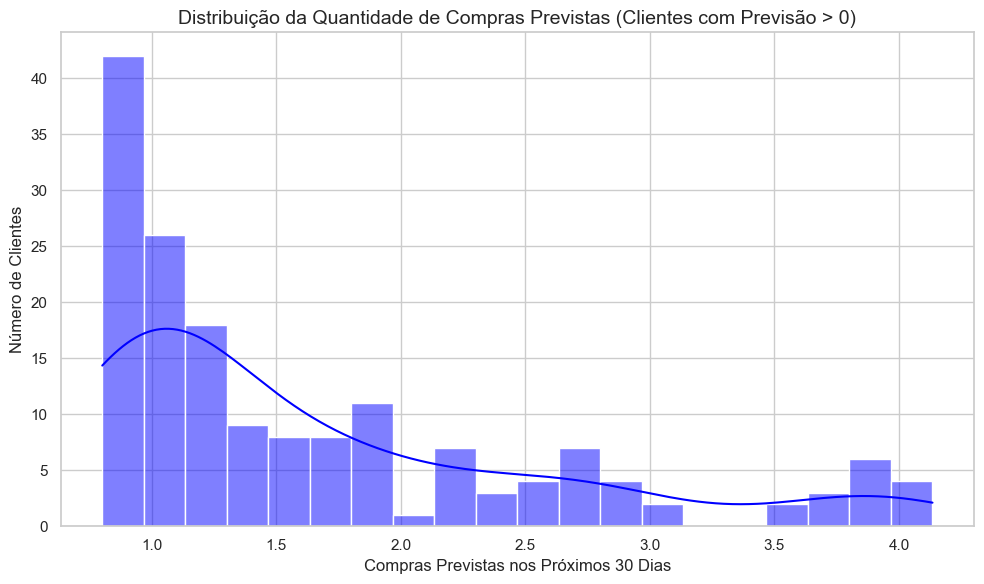

In [16]:
# Filtrar os clientes com previsão de compras > 0 utilizando .loc para garantir que uma Series seja retornada
dados = rfma.loc[rfma['predicted_purchases_30d'] > 0.8, 'predicted_purchases_30d']
plt.figure(figsize=(10, 6))
# Se o parâmetro edgecolor continuar causando problemas, remova-o:
sns.histplot(dados, bins=20, kde=True, color='blue')
# Caso deseje usar edgecolor, tente:
# sns.histplot(dados, bins=20, kde=True, color='blue', edgecolor='k')
plt.title('Distribuição da Quantidade de Compras Previstas (Clientes com Previsão > 0)', fontsize=14)
plt.xlabel('Compras Previstas nos Próximos 30 Dias', fontsize=12)
plt.ylabel('Número de Clientes', fontsize=12)
plt.tight_layout()
plt.show()